In [5]:
import gpytorch
import blop
blop.__file__

'C:\\Users\\megha\\src\\blop\\src\\blop\\__init__.py'

In [2]:
%run -i C:\\Users\\megha\\src\\blop\\src\\blop\\utils\\prepare_re_env.py --db-type=temp

In [6]:
RE

In [4]:
from bluesky.plans import list_scan

In [63]:
def generate_beam(dsh=0, ush=0, dsv=0, usv=0, ssa_inboard=-5, ssa_outboard=5, ssa_lower=-5, ssa_upper=5):

    res = 0.1
   
    x = np.arange(-10, 10, 0.1)
    y = np.arange(-10, 10, 0.1)
   
    kx = np.fft.fftfreq(n=len(x), d=0.1)
    ky = np.fft.fftfreq(n=len(y), d=0.1)
   
    X, Y = np.meshgrid(x, y)
    KX, KY = np.meshgrid(kx, ky)

    power_spectrum = 1 / (1e-2 + KX**2 + KY**2)

    white_noise = 5e-3 * np.random.standard_normal(size=X.shape)
    pink_noise = 5e-3 * np.real(np.fft.ifft2(power_spectrum * np.fft.fft2(np.random.standard_normal(size=X.shape))))
    background = 100 + 5e-3 * (X - Y) / X.max()
           
    x0 = ush - dsh
    y0 = usv - dsv
   
    x_width = np.sqrt(0.5 + 5e-1 * (ush + dsh - 1) ** 2)
    y_width = np.sqrt(0.25 + 5e-1 * (usv + dsv - 2) ** 2)
   
    beam = np.exp(-0.5 * (((X - x0)/x_width)**4 + ((Y - y0)/y_width)**4)) / (np.sqrt(2 * np.pi) * x_width * y_width)
   
    mask = (X > ssa_inboard) & (X < ssa_outboard) & (Y > ssa_lower) & (Y < ssa_upper)

    return beam * mask + white_noise + pink_noise
   


In [6]:
def process_beam(image): 

    image = image - image.min()
    
    flux = image.sum()
    im2 = image
    # Perform SVD
    U, S, Vt = np.linalg.svd(image)

    # Reconstruct the image using the first few singular values
    k = 1  # Number of singular values to use
    reconstructed = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
    
    column_sums = np.sum(reconstructed, axis = 0)
    row_sums = np.sum(reconstructed, axis = 1)
    
    height_threshold = np.mean(row_sums) + 0.75 * np.std(row_sums)
    
    # Find the indices where the row sums cross the threshold
    above_threshold_h = np.where(row_sums > height_threshold)[0]
    if len(above_threshold_h) > 1:
        start_index_h = above_threshold_h[0]
        end_index_h = above_threshold_h[-1]
        height = end_index_h-start_index_h
        im2 = im2[start_index_h: end_index_h]
        ypos = (end_index_h+start_index_h)/2
    else: 
        height = 1
        ypos = 0
    
    width_threshold = np.mean(column_sums) + 0.75 * np.std(column_sums)
    above_threshold_w = np.where(column_sums > width_threshold)[0]
    # Find the indices where the column sums cross the threshold
    if len(above_threshold_w) > 1:
        start_index_w = above_threshold_w[0]
        end_index_w = above_threshold_w[-1]
        width = end_index_w-start_index_w
        im2 = im2 [:, start_index_w: end_index_w]
        xpos = (end_index_w+start_index_w)/2
    else: 
        width = 1
        xpos = 0

    flux = im2.sum() if im2.sum() > 0 else 1
    #return width, height, flux
    return width, height, flux, xpos, ypos
    #return np.log(width), np.log(height), np.log(flux)

In [8]:
from blop import DOF, Objective, Agent


def digestion_to_generate_beam(df, **kwargs):

    if "image" not in df.columns:
        df.loc[:, "image"] = None

    for index, entry in df.iterrows():

        image = generate_beam(entry.x1, entry.x2, entry.x3, entry.x4)

        w, h, f, x, y = process_beam(image)

        # if f < 0.7 * agent.table.flux.max():
        #     f = w = h = x = y = np.nan

        df.at[index, "image"] = image
        df.loc[index, "flux"] = f
        df.loc[index, "width"] = w
        df.loc[index, "height"] = h
        df.loc[index, "x_pos"] = x
        df.loc[index, "y_pos"] = y
        
        #ADD CONSTRAINTS HERE

    return df


dofs = [DOF(name="x1", search_domain=(-5, 5)), 
      DOF(name="x2", search_domain=(-5, 5)), 
      DOF(name="x3", search_domain=(-5, 5)), 
      DOF(name="x4", search_domain=(-5, 5))]

objectives = [
    Objective(name="width", transform="log", target="min"),
    Objective(name="height", transform="log", target="min"),
    Objective(name="flux", transform="log"),
    Objective(name="x_pos", weight=0),
    Objective(name="y_pos", weight=0),
]


agent = Agent(dofs=dofs, 
              objectives=objectives, 
              dets=[],
              digestion=digestion_to_generate_beam,
              db=db)

TypeError: Agent.__init__() got an unexpected keyword argument 'dets'

In [273]:
RE(agent.learn("qr", n=32), verbose=True)



Transient Scan ID: 25     Time: 2024-07-02 15:27:16
Persistent Unique Scan ID: 'df81dd1b-095d-4d71-b592-1b9ccfda2a94'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+
|   seq_num |       time |         x1 |         x2 |         x3 |         x4 |
+-----------+------------+------------+------------+------------+------------+
|         1 | 15:27:16.3 |     -1.067 |      0.211 |      0.902 |     -0.277 |
|         2 | 15:27:16.3 |      0.465 |      1.084 |     -0.361 |     -2.218 |
|         3 | 15:27:16.3 |      1.708 |     -2.357 |     -3.227 |     -1.213 |
|         4 | 15:27:16.4 |      4.464 |     -4.724 |     -4.745 |     -1.655 |
|         5 | 15:27:16.4 |     -0.441 |     -4.549 |     -1.841 |     -3.741 |
|         6 | 15:27:16.5 |      1.089 |     -4.175 |      1.915 |     -3.753 |
|         7 | 15:27:16.5 |      2.583 |     -1.816 |      1.052 |     -3.331 |
|         8 | 15:27:16.6 |      3.838 |      0.388 |      2.551 |   

('df81dd1b-095d-4d71-b592-1b9ccfda2a94',)

In [294]:
agent.redigest()

In [1]:
for iteration in range(1):

    #train targets may not be the right thing to use? 
    w_mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.width.model.likelihood, agent.objectives.width.model)
    w_mlls = w_mll(agent.objectives.width.model(agent.train_inputs()), agent.train_targets()[:, 0].unsqueeze(-1)).detach()
    h_mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.height.model.likelihood, agent.objectives.height.model)
    h_mlls = h_mll(agent.objectives.height.model(agent.train_inputs()), agent.train_targets()[:, 1].unsqueeze(-1)).detach()
    x_mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.x_pos.model.likelihood, agent.objectives.x_pos.model)
    x_mlls = x_mll(agent.objectives.x_pos.model(agent.train_inputs()), agent.train_targets()[:, 3].unsqueeze(-1)).detach()
    y_mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.y_pos.model.likelihood, agent.objectives.y_pos.model)
    y_mlls = y_mll(agent.objectives.y_pos.model(agent.train_inputs()), agent.train_targets()[:, 4].unsqueeze(-1)).detach()

    #use y-mean/ std.
    agent.table.loc[:, "w_loss"] = w_mlls.numpy()
    agent.table.loc[:, "h_loss"] = h_mlls.numpy()
    agent.table.loc[:, "x_loss"] = x_mlls.numpy()
    agent.table.loc[:, "y_loss"] = y_mlls.numpy()
    
    mask  = ((agent.table.w_loss < 1.25 * np.quantile(w_mlls, q=0.25))
             | (agent.table.h_loss < 1.25 * np.quantile(h_mlls, q=0.25))
             | (agent.table.x_loss < 1.2 * np.quantile(x_mlls, q=0.25))
             | (agent.table.y_loss < 1.2 * np.quantile(y_mlls, q=0.25))
             | (agent.table.flux < 0.7 * agent.table.flux.max()))


    # Maybe flux filter should be after other mask? to account for the fluke flux readings? 
    # agent.table.loc[agent.table.flux < 0.7 * agent.table.flux.max(), "width"] = np.nan
    # agent.table.loc[agent.table.flux < 0.7 * agent.table.flux.max(), "height"] = np.nan
    # agent.table.loc[agent.table.flux < 0.7 * agent.table.flux.max(), "flux"] = np.nan

    agent.table.loc[mask, "width"]= np.nan
    agent.table.loc[mask, "height"]= np.nan
    agent.table.loc[mask, "flux"]= np.nan

    #RE(agent.learn("qei", n=2, iterations=4))

NameError: name 'gpytorch' is not defined

In [295]:
agent.table

,x1,x2,x3,x4,width,height,flux,x_pos,y_pos,time,image,acqf,w_loss,h_loss,x_loss,y_loss
0,-1.066854,0.211335,0.901968,-0.276897,32.0,25.0,172.618784,112.0,87.5,2024-07-02 19:27:16.304254770,"[[-6.03169016244378e-06, 0.006089799603391929,...",quasi-random,-8.394244,-750.095082,-1.254178e+06,-4.821405e+05
1,0.464621,1.084006,-0.361100,-2.217964,20.0,61.0,184.792044,106.0,82.5,2024-07-02 19:27:16.333054066,"[[-0.028268880168484698, -0.02012616174211317,...",quasi-random,-6.452725,-1142.389792,-1.113147e+06,-4.189338e+05
2,1.708226,-2.356818,-3.226538,-1.212876,26.0,76.0,165.992390,64.0,112.0,2024-07-02 19:27:16.395330191,"[[0.0015719709633047196, -0.004716765930569683...",quasi-random,-7.125073,-1213.212203,-3.920115e+05,-7.932911e+05
3,4.464061,-4.724279,-4.745273,-1.654670,33.0,199.0,284.784416,65.5,99.5,2024-07-02 19:27:16.441290379,"[[-0.0061739979524717305, 0.004431449771051797...",quasi-random,-10.937594,-1164.506749,-2.352859e+06,-3.015128e+05
4,-0.440846,-4.549427,-1.841036,-3.740902,122.0,92.0,463.484938,112.0,95.0,2024-07-02 19:27:16.493485212,"[[-0.004248018422291875, -0.010171067345317766...",quasi-random,-9.846397,-1746.875542,-5.414554e+05,-6.156965e+05
5,1.089242,-4.174534,1.915403,-3.753268,199.0,69.0,525.565224,99.5,72.5,2024-07-02 19:27:16.547241211,"[[0.0038465385820311087, 0.004353199897933262,...",quasi-random,-9.944948,-1062.206687,-6.571581e+05,-1.568141e+05
6,2.582832,-1.815581,1.051517,-3.330968,14.0,40.0,100.416394,58.0,71.0,2024-07-02 19:27:16.584445953,"[[-0.0037918077920827357, -0.00960143773513658...",quasi-random,-5.251707,-916.695933,-3.320444e+05,-3.015128e+05
7,3.838072,0.388045,2.550786,-4.474911,58.0,31.0,83.771345,51.0,48.5,2024-07-02 19:27:16.652131796,"[[0.009611293628549625, 0.014445635863593128, ...",quasi-random,-14.678798,-1366.901799,-7.664904e+05,-4.605783e+05
8,2.333621,3.019368,4.167350,-2.807384,131.0,178.0,853.489971,102.5,107.0,2024-07-02 19:27:16.707571745,"[[0.00956298528112286, 0.015540036115200464, 0...",quasi-random,-17.814757,-1164.506749,-9.805261e+05,-1.207266e+06
9,-2.605452,2.570446,2.381107,-1.963818,10.0,20.0,49.700426,145.0,61.0,2024-07-02 19:27:16.743856907,"[[-0.005606742602225327, -0.01031921673945511,...",quasi-random,-12.083539,-686.152355,-1.276622e+06,-2.326734e+05


In [288]:
agent.objectives

,0,1,2,3,4
name,width,height,flux,x_pos,y_pos
description,,,,,
type,continuous,continuous,continuous,continuous,continuous
kind,fitness,fitness,fitness,fitness,fitness
target,min,min,max,max,max
transform,log,log,log,,
domain,"(0.0, inf)","(0.0, inf)","(0.0, inf)","(-inf, inf)","(-inf, inf)"
trust_domain,,,,,
weight,1.0,1.0,1.0,0.0,0.0
units,,,,,


In [105]:
agent.table.loc[agent.table.flux < 200, "flux"] = np.nan

In [265]:
agent.redigest()

In [167]:
agent.objectives.width.model.train_targets

tensor([ 1.5854, -1.0053, -1.8175,  0.2888,  0.7995,  0.2582,  1.1410, -1.0181,
        -1.8100,  1.0351,  0.3844, -0.1603, -1.8100,  1.2549,  0.4177, -1.2537,
         1.0351,  2.4709,  1.5854, -0.4112, -0.0417,  0.1990, -0.3722, -0.1829,
         0.2582, -0.2910, -1.3588, -0.6586,  0.1990,  0.0605,  0.0085, -0.3918,
        -0.1829, -0.3918,  0.7149,  0.0343, -1.8175,  0.7149,  0.7995, -0.2700],
       dtype=torch.float64)

In [163]:
w_mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.width.model.likelihood, agent.objectives.width.model)
w_mlls = w_mll(agent.objectives.width.model(agent.train_inputs()), agent.train_targets()[:, 0].unsqueeze(-1)).detach()
h_mll = gpytorch.mlls.ExactMarginalLogLikelihood(agent.objectives.height.model.likelihood, agent.objectives.height.model)
h_mlls = h_mll(agent.objectives.height.model(agent.train_inputs()), agent.train_targets()[:, 1].unsqueeze(-1)).detach()

agent.table.loc[:, "w_loss"] = w_mlls.numpy()
agent.table.loc[:, "h_loss"] = h_mlls.numpy()

agent.table.loc[w_loss < 1.2 * np.quantile(w_mlls, q=0.25), "width"] = np.nan
agent.table.loc[w_loss < 1.2 * np.quantile(w_mlls, q=0.25), "height"] = np.nan
agent.table.loc[w_loss < 1.2 * np.quantile(w_mlls, q=0.25), "flux"] = np.nan
agent.table.loc[h_loss < 1.2 * np.quantile(h_mlls, q=0.25), "width"] = np.nan
agent.table.loc[h_loss < 1.2 * np.quantile(h_mlls, q=0.25), "height"] = np.nan
agent.table.loc[h_loss < 1.2 * np.quantile(h_mlls, q=0.25), "flux"] = np.nan


KeyError: "None of [Index([False, False,  True, False, False, False, False, False,  True, False,\n       False, False, False, False, False, False, False, False, False, False,\n       False, False, False, False, False, False, False,  True, False, False,\n       False, False, False, False, False, False, False, False, False, False],\n      dtype='bool')] are in the [index]"

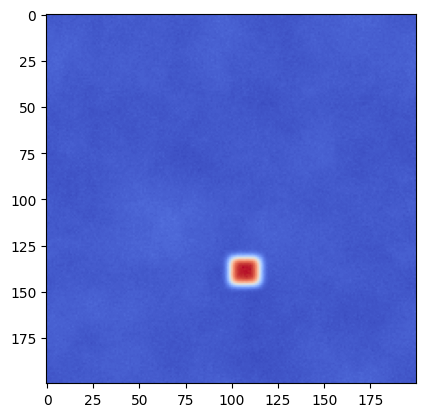

In [238]:
plt.imshow(agent.table.image[0])

In [157]:
#w_mlls < 1.2 * np.quantile(w_mlls, q=0.25)
agent.train_targets()[:, 0]
agent.objectives.height.model(agent.train_inputs())

MultivariateNormal(loc: torch.Size([40]))

In [154]:
X = agent.train_inputs()
Y = agent.train_targets()

In [97]:
agent.raw_inputs()

tensor([[ 2.0816e-01,  2.9500e-01, -1.9739e+00,  7.6539e-01],
        [-1.8801e+00,  3.5517e-01, -4.4791e+00,  2.8802e+00],
        [-2.9763e+00,  4.4397e+00, -2.9355e+00,  4.9397e+00],
        [-4.4720e+00, -2.7654e-01, -1.3016e-01,  3.4011e+00],
        [-3.9384e+00,  1.0012e+00,  2.1347e+00,  1.6499e+00],
        [-1.5052e+00, -9.2328e-01,  2.7870e+00,  2.0543e+00],
        [ 7.8081e-01, -9.8513e-01,  2.9215e-01,  4.3245e+00],
        [-5.6323e-01, -4.9860e+00, -2.2987e+00,  3.7839e+00],
        [ 2.3093e+00, -4.4237e+00, -4.8039e+00,  2.3044e+00],
        [ 2.7757e+00, -3.7333e-01, -2.6353e+00,  5.1553e-01],
        [ 1.1677e+00,  3.1402e+00, -4.1578e+00, -2.9252e+00],
        [ 3.8263e+00,  1.5948e+00, -3.2807e+00, -4.8898e+00],
        [ 3.7399e+00, -3.6866e+00, -1.0765e+00, -3.2923e+00],
        [ 1.3939e+00, -1.5161e+00, -1.3285e+00, -3.8878e+00],
        [-8.9294e-01, -1.5739e+00, -3.8331e+00, -2.2517e+00],
        [-4.1716e+00, -3.1632e+00, -3.5811e+00, -5.6333e-01],
        

In [98]:
agent.train_inputs()

tensor([[0.5208, 0.5295, 0.3026, 0.5765],
        [0.3120, 0.5355, 0.0521, 0.7880],
        [0.2024, 0.9440, 0.2065, 0.9940],
        [0.0528, 0.4723, 0.4870, 0.8401],
        [0.1062, 0.6001, 0.7135, 0.6650],
        [0.3495, 0.4077, 0.7787, 0.7054],
        [0.5781, 0.4015, 0.5292, 0.9324],
        [0.4437, 0.0014, 0.2701, 0.8784],
        [0.7309, 0.0576, 0.0196, 0.7304],
        [0.7776, 0.4627, 0.2365, 0.5516],
        [0.6168, 0.8140, 0.0842, 0.2075],
        [0.8826, 0.6595, 0.1719, 0.0110],
        [0.8740, 0.1313, 0.3924, 0.1708],
        [0.6394, 0.3484, 0.3671, 0.1112],
        [0.4107, 0.3426, 0.1167, 0.2748],
        [0.0828, 0.1837, 0.1419, 0.4437],
        [0.1699, 0.6496, 0.4224, 0.3474],
        [0.3415, 0.8710, 0.3347, 0.4346],
        [0.4033, 0.8792, 0.5592, 0.6170],
        [0.4982, 0.7148, 0.8430, 0.2323],
        [0.7855, 0.7533, 0.6816, 0.3383],
        [0.7072, 0.7203, 0.5935, 0.3802],
        [0.9737, 0.9970, 0.4570, 0.6420],
        [0.6786, 0.9357, 0.8087, 0

In [22]:
RE(list_scan([], dof.device, [0, 1, 2]))



Transient Scan ID: 1     Time: 2024-06-27 13:56:51
Persistent Unique Scan ID: 'fb7a8ea1-6b07-4c31-9ddf-922d09798048'
New stream: 'primary'
+-----------+------------+------------+
|   seq_num |       time |         x1 |
+-----------+------------+------------+
|         1 | 13:56:51.7 |          0 |
|         2 | 13:56:51.7 |          1 |
|         3 | 13:56:51.7 |          2 |
+-----------+------------+------------+
generator list_scan ['fb7a8ea1'] (scan num: 1)





('fb7a8ea1-6b07-4c31-9ddf-922d09798048',)

In [25]:
db[-1].table()

,time,x1
seq_num,,
1,2024-06-27 17:56:51.701417923,0
2,2024-06-27 17:56:51.723222733,1
3,2024-06-27 17:56:51.744431257,2


In [254]:
agent.table

,x1,x2,x3,x4,flux,width,height,x_pos,y_pos,time,image,acqf
0,-1.033349,-1.635614,1.021084,0.526702,167.097213,NaN,14.0,91.0,95.0,2024-07-01 18:35:49.662880182,"[[-0.008164756456631223, -0.011080264072546486...",quasi-random
1,-2.669048,0.256839,3.199808,0.884189,189.293940,NaN,33.0,126.0,77.5,2024-07-01 18:35:49.676720381,"[[-0.007350768567343225, -0.009489198600861655...",quasi-random
2,-1.454084,3.454846,3.843554,2.327837,60.676620,NaN,32.0,143.5,98.0,2024-07-01 18:35:49.706160784,"[[0.016802211091750018, 0.013640417392836375, ...",quasi-random
3,0.756484,3.272168,0.654690,3.507212,206.332220,NaN,36.0,125.5,127.0,2024-07-01 18:35:49.725135565,"[[-0.007810475129157921, -0.006486345615399472...",quasi-random
4,3.214062,2.681091,-0.150737,0.994845,201.719895,NaN,23.0,94.5,111.5,2024-07-01 18:35:49.748385906,"[[-0.004234800918978786, -0.005808621324469014...",quasi-random
5,3.812462,3.848740,2.532175,-0.371533,154.061038,NaN,12.0,106.0,71.0,2024-07-01 18:35:49.772793770,"[[-0.015066921401557319, -0.008965283081406431...",quasi-random
6,0.037229,2.359247,4.506457,-1.434294,496.537016,NaN,197.0,104.0,98.5,2024-07-01 18:35:49.816976786,"[[0.0029911310758347553, 0.007206556465342053,...",quasi-random
7,-3.437131,4.109314,1.971028,-4.213492,512.523542,NaN,67.0,99.5,114.5,2024-07-01 18:35:49.844452381,"[[0.00997021307543411, 0.007365424153799782, 0...",quasi-random
8,-2.132448,2.180228,0.077217,-2.769871,133.774117,NaN,52.0,140.5,77.0,2024-07-01 18:35:49.866155863,"[[-0.008030966030459425, -0.003416008781542214...",quasi-random
9,-0.894705,4.934767,-1.305560,-1.694722,588.612375,NaN,100.0,75.0,55.0,2024-07-01 18:35:49.896762609,"[[0.022812652277011333, 0.0221495842485953, 0....",quasi-random


In [ ]:
agent.aquisition_function